In [1]:
from tensorflow.keras.datasets import mnist
import torchvision
from torchvision import transforms
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from time import time

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0


X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [4]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Epoch 0 - Training loss: 0.3512938593162784
Epoch 1 - Training loss: 0.14829087452387124
Epoch 2 - Training loss: 0.09999152141283633
Epoch 3 - Training loss: 0.07503677451157018
Epoch 4 - Training loss: 0.05956741062073367
Epoch 5 - Training loss: 0.04759526860141662
Epoch 6 - Training loss: 0.03837965383578632
Epoch 7 - Training loss: 0.030847944075806138
Epoch 8 - Training loss: 0.027158577432436472
Epoch 9 - Training loss: 0.023294331372228028
Epoch 10 - Training loss: 0.017619920046117628
Epoch 11 - Training loss: 0.016364298227643938
Epoch 12 - Training loss: 0.013972705951685507
Epoch 13 - Training loss: 0.015096665720685977
Epoch 14 - Training loss: 0.01024866050976774

Training Time (in minutes) = 0.3784499843915304
Predicted Digit = 3
Number Of Images Tested = 10000

Model Accuracy = 0.9784


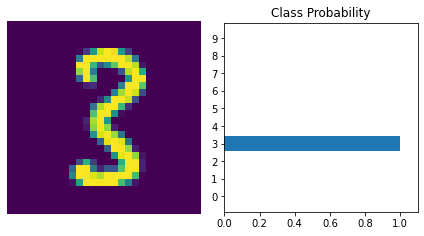

In [5]:
# Now let's start training the network

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

def train_model(model, x_train, x_test, y_train, y_test, epochs=15):
    transform = transforms.Compose([transforms.Normalize((0,), (1,)),])
    
    #trainset = datasets.MNIST('../', download=True, train=True, transform=transform)
    #valset = datasets.MNIST('../', download=True, train=False, transform=transform)
    trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.long))
    valset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test).type(torch.long))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

    criterion = nn.NLLLoss()
    images, labels = next(iter(trainloader))
    images = images.view(images.shape[0], -1)
    labels = labels

    logps = model(images)
    loss = criterion(logps, labels)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    time0 = time()
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:

            images = images.view(images.shape[0], -1)
            labels = labels

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)


    images, labels = next(iter(valloader))

    img = images[0].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    view_classify(img.view(1, 28, 28), ps)

    correct_count, all_count = 0, 0
    for images,labels in valloader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)
            with torch.no_grad():
                logps = model(img)


            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))
    
    return model
    
model = train_model(model, X_train, X_test, y_train, y_test, epochs=15)

In [6]:
def get_network_outputs(model, dataloader):
    """ Returns the network outputs and original labels of samples in the given dataloader.
    """
    network_outputs = list()
    labels = list()
    with torch.no_grad():
        for x, y in dataloader:
            network_outputs.append(model(x))
            labels.append(y)
            
    network_outputs = np.concatenate(network_outputs)
    labels = np.concatenate(labels)
    
    return network_outputs, labels

def add_adversarial_noise(model, dataloader, eps=3e-2):
    """ Returns an ndarray of adversarially perturbed versions of the data passed in with the dataloader, 
        generated by a white-box FGSM attack on the provided network.
    """
    adv_images = list()
    for x, y in dataloader:
        adv_images.append(fast_gradient_method(model, x, eps, np.inf).detach().numpy())
            
    adv_images = np.concatenate(adv_images)
    
    return adv_images
    

def one_vs_all_dataloader(data, labels, digit):
    """ Returns dataloader with labels modified so that samples belonging to the specified class have a 
        label of 1, and all other samples have a label of 0
    """
    current_digit_idx = np.where(labels == digit)
    other_digits_idx = np.where(labels!=digit)
    
    labels[current_digit_idx] = 1
    labels[other_digits_idx] = 0
    
    dataset = torch.utils.data.TensorDataset(torch.Tensor(data), torch.Tensor(labels).type(torch.long))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    
    return dataloader

In [9]:
def model_confidence_intervals(clean_outputs, adv_outputs, labels, curr_digit):
    """ Returns the indices of outputs for which the clean image is correctly classified and
        the adversarial version is not. Return type is a dict, where the keys indicate intervals
        of confidence with which the model incorrectly classified the adversarial data.
    """
    confidence_range_pair_indices = dict()
    
    for idx in range(clean_outputs.shape[0]):
        sample_is_curr_digit = labels[idx] == 1
        if not sample_is_curr_digit:
            continue
        
        logps = clean_outputs[idx]
        adv_logps = adv_outputs[idx]
        
        ps = np.exp(logps)
        probab = list(ps)
        pred_label = probab.index(max(probab))

        # If original image is correctly classified
        if (pred_label == curr_digit):
            adv_ps = np.exp(adv_logps)
            adv_probab = list(adv_ps)
            adv_pred_label = adv_probab.index(max(adv_probab))
            
            # If adversarial version of image is misclassified
            if (curr_digit != adv_pred_label):
                # Identify confidence range and save the model output for that image
                confidence = adv_ps.max().item()
                if ((confidence > .5 and confidence <= .6) and not ".5-.6" in confidence_range_pair_indices):
                    confidence_range_pair_indices[".5-.6"] = idx
                    
                elif ((confidence > .6 and confidence <= .7) and not ".6-.7" in confidence_range_pair_indices):
                    confidence_range_pair_indices[".6-.7"] = idx
                    
                elif ((confidence > .7 and confidence <= .8) and not ".7-.8" in confidence_range_pair_indices):
                    confidence_range_pair_indices[".7-.8"] = idx
                    
                elif ((confidence > .8 and confidence <= .9) and not ".8-.9" in confidence_range_pair_indices):
                    confidence_range_pair_indices[".8-.9"] = idx
                    
                elif ((confidence > .9 and confidence <= 1) and not ".9-1" in confidence_range_pair_indices):
                    confidence_range_pair_indices[".9-1"] = idx

    return confidence_range_pair_indices

In [8]:
def high_confidence_misclassified_sample_index(clean_outputs, adv_outputs, labels, curr_digit):
    """ Returns the index of an output for which the clean image is correctly classified and the
        adversarial image is misclassified with high (>90%) confidence.
    """
    for idx in range(clean_outputs.shape[0]):
        sample_is_curr_digit = labels[idx] == 1
        if not sample_is_curr_digit:
            continue
        
        logps = clean_outputs[idx]
        adv_logps = adv_outputs[idx]

        ps = np.exp(logps)
        probab = list(ps)
        pred_label = probab.index(max(probab))

        # If original image is correctly classified
        if (pred_label == curr_digit):
            adv_ps = np.exp(adv_logps)
            adv_probab = list(adv_ps)
            adv_pred_label = adv_probab.index(max(adv_probab))

            # If adversarial version of image is misclassified with high confidence
            confidence = adv_ps.max().item()
            if ((curr_digit != adv_pred_label) and (confidence > .9 and confidence <= 1)):
                return idx

### Comparing distance from cluster for advsersarial samples misclassified with different levels of confidence

In [10]:
curr_digit = 0
eps = 3e-2

loader = one_vs_all_dataloader(X_test, y_test, curr_digit)

# Generate adversarial samples
adv_data = add_adversarial_noise(model, loader, eps=eps)
adv_loader = one_vs_all_dataloader(adv_data, y_test, curr_digit)

# Get model outputs for clean and adversarial data
clean_outputs, labels = get_network_outputs(model, loader)
adv_outputs, _ = get_network_outputs(model, adv_loader)

interval_indices = model_confidence_intervals(clean_outputs, adv_outputs, labels, curr_digit)

In [11]:
intervals = [".5-.6", ".6-.7", ".7-.8", ".8-.9", ".9-1"]

num_sample_outputs = clean_outputs.shape[0]
adv_intervals = np.zeros((len(intervals), 10), dtype=float)
for i, conf_interval in enumerate(intervals):
    # Put each of the adversarial samples found into an array to append to the clean output data
    adv_intervals[i] = adv_outputs[interval_indices[conf_interval]]
    # Replace single index in interval indices with a tuple of indices: first being the index of
    # the clean sample in intervals_data (defined below) and second being the index of that 
    # sample's adversarial counterpart
    interval_indices[conf_interval] = (interval_indices[conf_interval], num_sample_outputs + i)

# Data to visualize with TSNE: clean outputs with adversarial outputs in different confidence ranges
intervals_data = np.append(clean_outputs, adv_intervals, axis=0)
print(intervals_data.shape)

(10005, 10)


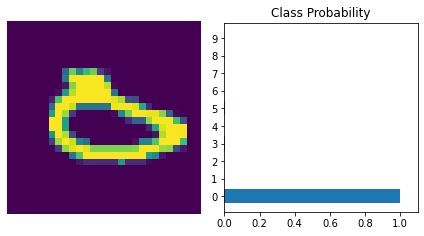

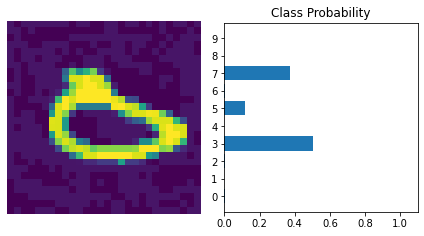

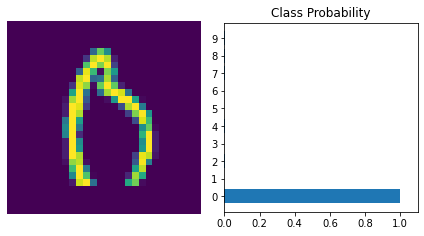

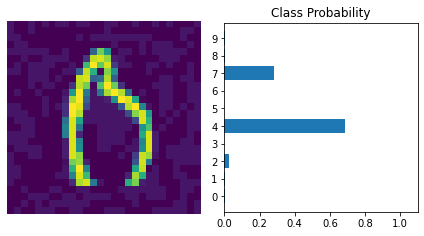

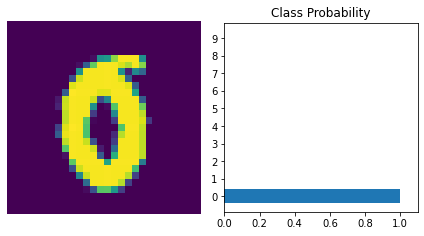

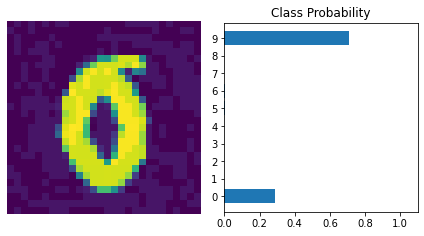

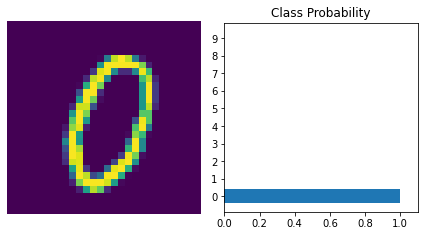

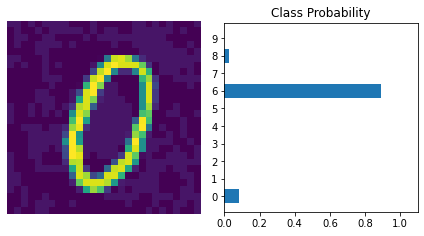

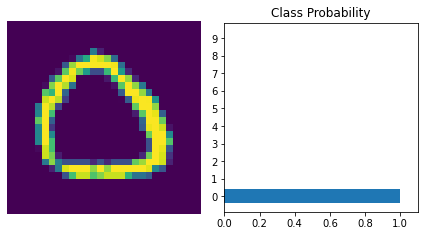

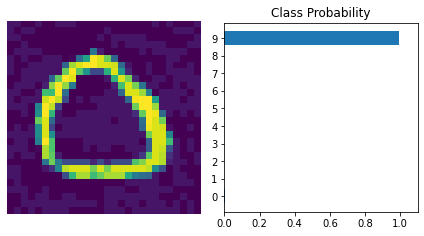

In [12]:
for i, conf_interval in enumerate(intervals):
    view_classify(torch.from_numpy(X_test[interval_indices[conf_interval][0]]), torch.from_numpy(np.exp(intervals_data[interval_indices[conf_interval][0]])))
    view_classify(torch.from_numpy(adv_data[interval_indices[conf_interval][0]]), torch.from_numpy(np.exp(intervals_data[interval_indices[conf_interval][1]])))

In [13]:
tsne_intervals = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(intervals_data)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


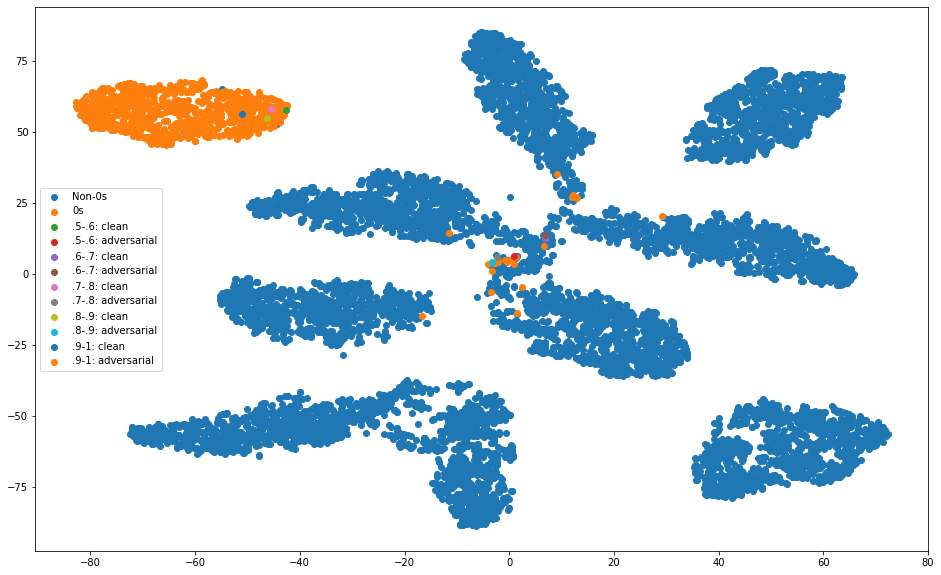

In [14]:
other_digits_idx = np.where(labels == 0)
current_digit_idx = np.where(labels == 1)

plt.figure(figsize=(16,10))
plt.scatter(tsne_intervals[other_digits_idx,0], tsne_intervals[other_digits_idx,1], label="Non-" + str(curr_digit) + "s")
plt.scatter(tsne_intervals[current_digit_idx,0], tsne_intervals[current_digit_idx,1], label=str(curr_digit) + "s")
for conf_interval in intervals:
    clean_idx = interval_indices[conf_interval][0]
    adv_idx = interval_indices[conf_interval][1]
    plt.scatter(tsne_intervals[clean_idx,0], tsne_intervals[clean_idx,1], label=conf_interval + ": clean")
    plt.scatter(tsne_intervals[adv_idx,0], tsne_intervals[adv_idx,1], label=conf_interval + ": adversarial")
plt.legend()

### Comparing distance between clean sample and that sample with added adversarial noise in input and output space

In [19]:
curr_digit = 0
eps = 3e-2

loader = one_vs_all_dataloader(X_test, y_test, curr_digit)

# Generate adversarial samples
adv_data = add_adversarial_noise(model, loader, eps=eps)
adv_loader = one_vs_all_dataloader(adv_data, y_test, curr_digit)

# Get model outputs for clean and adversarial data
clean_outputs, labels = get_network_outputs(model, loader)
adv_outputs, _ = get_network_outputs(model, adv_loader)

# Get index of a sample that is misclassified with high confidence by the model
index_of_sample = high_confidence_misclassified_sample_index(clean_outputs, adv_outputs, labels, curr_digit)
print(index_of_sample)

126


In [20]:
clean_outputs.shape

(10000, 10)

In [21]:
# Concatenate clean and adversarial samples into a single ndarray each (for passing to TSNE transform)
input_data = np.append(X_test, np.expand_dims(adv_data[index_of_sample], axis=0), axis=0)
output_data = np.append(clean_outputs, np.expand_dims(adv_outputs[index_of_sample], axis=0), axis=0)

index_of_adv_sample = len(X_test)

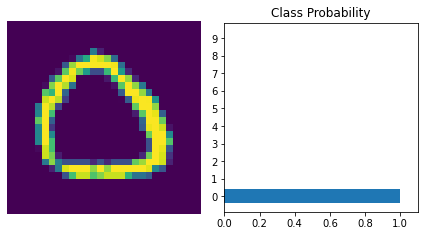

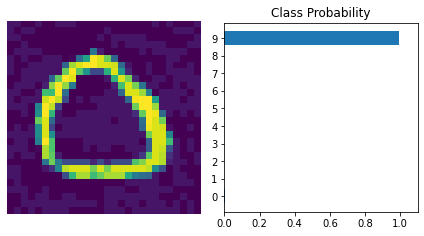

In [22]:
view_classify(torch.from_numpy(input_data[index_of_sample]), torch.from_numpy(np.exp(output_data[index_of_sample])))
view_classify(torch.from_numpy(input_data[index_of_adv_sample]), torch.from_numpy(np.exp(output_data[index_of_adv_sample])))

In [23]:
pca = PCA(n_components = 50, random_state = 42)

In [24]:
tsne_input = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(pca.fit_transform(input_data))

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


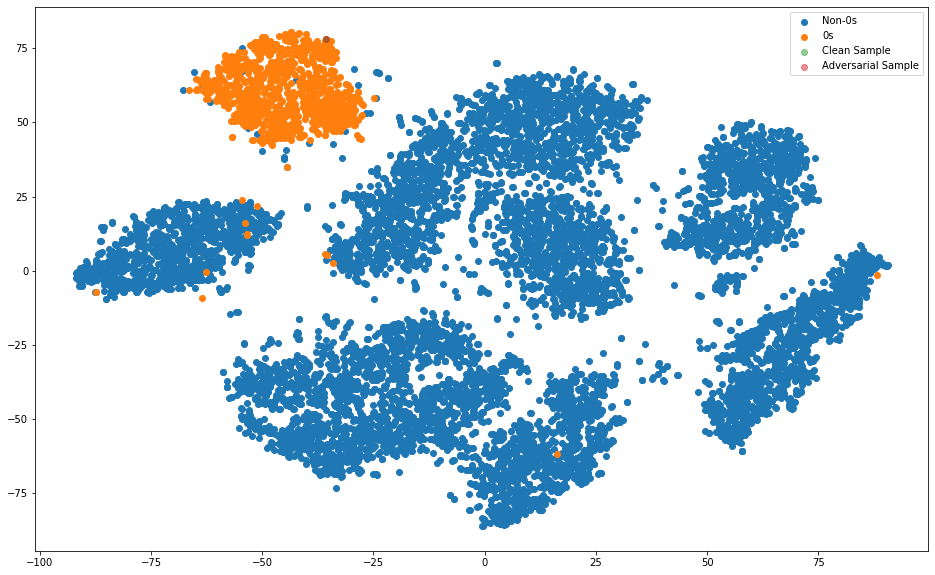

In [25]:
other_digits_idx = np.where(labels == 0)
current_digit_idx = np.where(labels == 1)

plt.figure(figsize=(16,10))
plt.scatter(tsne_input[other_digits_idx,0], tsne_input[other_digits_idx,1], label="Non-" + str(curr_digit) + "s")
plt.scatter(tsne_input[current_digit_idx,0], tsne_input[current_digit_idx,1], label=str(curr_digit) + "s")
plt.scatter(tsne_input[index_of_sample,0], tsne_input[index_of_sample,1], label="Clean Sample", alpha=0.5)
plt.scatter(tsne_input[index_of_adv_sample,0], tsne_input[index_of_adv_sample,1], label="Adversarial Sample", alpha=0.5)
plt.legend()

In [26]:
tsne_output = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(output_data)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


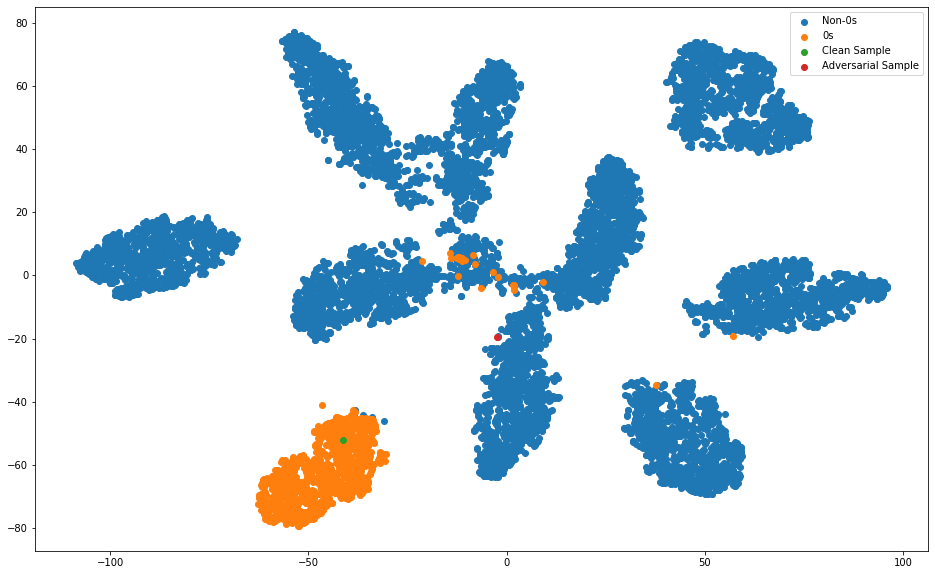

In [27]:
other_digits_idx = np.where(labels == 0)
current_digit_idx = np.where(labels == 1)

plt.figure(figsize=(16,10))
plt.scatter(tsne_output[other_digits_idx,0], tsne_output[other_digits_idx,1], label="Non-" + str(curr_digit) + "s")
plt.scatter(tsne_output[current_digit_idx,0], tsne_output[current_digit_idx,1], label=str(curr_digit) + "s")
plt.scatter(tsne_output[index_of_sample,0], tsne_output[index_of_sample,1], label="Clean Sample")
plt.scatter(tsne_output[index_of_adv_sample,0], tsne_output[index_of_adv_sample,1], label="Adversarial Sample")
plt.legend()